In [4]:
from PIL import Image
import numpy as np

In [5]:
group_num = 25
variant_count = 10
variant_num = (group_num - 1) % variant_count + 1
variant_num

5

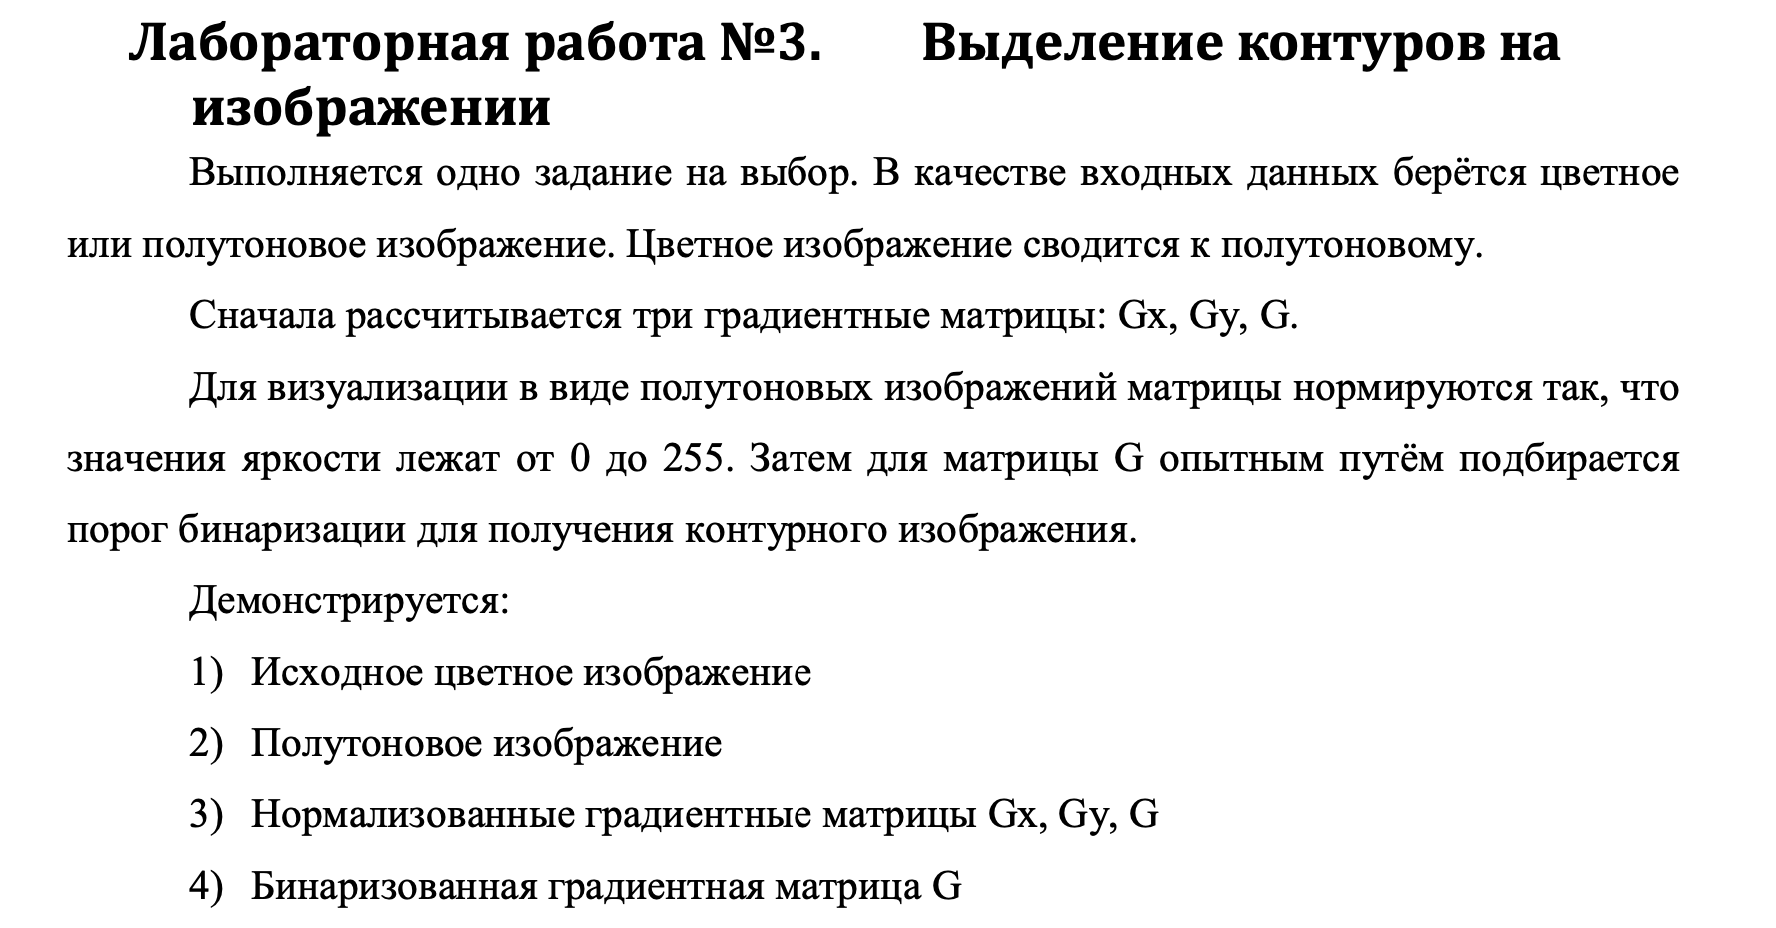

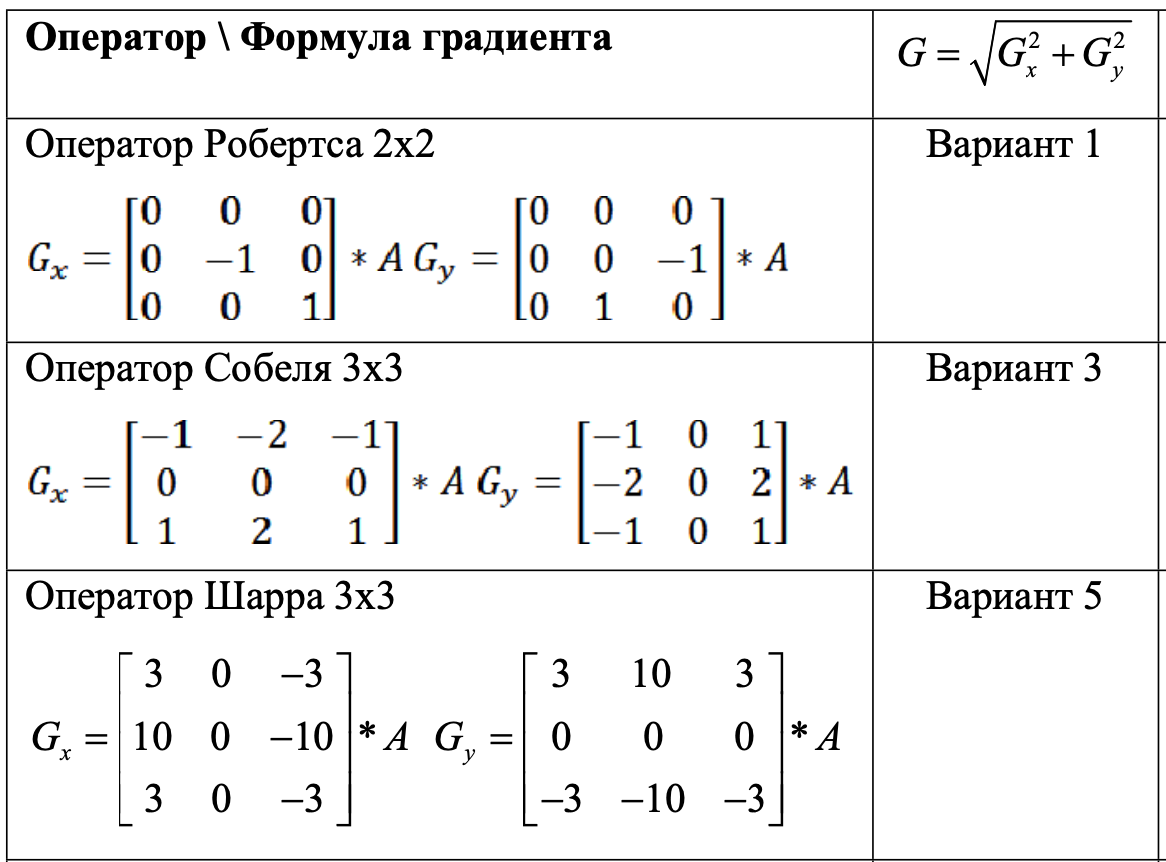

#### План реализации  
1. Перенести функцию grayscale в ноутбук
2. Загрузка изображения и приведение к grayscale
3. Выбираем окно , как во всех предыдущих лабах с window size = 3 для моего варианта и получается подсчитываем Gx (это получается перемножение оператора на окно и потом вычисление суммы матрицы), Gy , G = sqrt (Gx^2 + Gy^2) и заносим в матрицу G_matrix значение в x,y позицию значение G. Добавить в функцию возможность добавления оператора и указания окна для оператора.
4. Нормализуем матрицу G: находим максимальный элемент матрицы, после этого по формуле: G_new(x,y) = G_matrix(x,y) / max_el(G_matrix) * 255
5. Создаем пороговую матрицу T размером с G_new и значения например 155 (опытным путем надо определить) и дальше делаем итоговую матрицу G_new > T , которая будет бинарная и после этого переводим эту бинарную матрицу в диапозон значений 0..255 , умножив на 255, как в 1 лабе

In [6]:
def photoshop_grayscale(image):
    result = Image.new('L', (image.width, image.height))

    for x in range(result.width):
        for y in range(result.height):
            pixel = image.getpixel((x, y))
            new_pixel = int(round(pixel[0] * 0.3 + pixel[1] * 0.59 + pixel[2] * 0.11))
            result.putpixel((x, y), new_pixel)

    return result

In [7]:
def christian_binarize(image, window_size=15, k=0.5):
    gray_img = photoshop_grayscale(image)
    width, height = gray_img.size
    
    # Convert the grayscale image to a NumPy array
    gray_arr = np.asarray(gray_img, dtype=np.uint8)
    
    # Compute the global mean and standard deviation of the image
    global_mean = np.mean(gray_arr)
    global_std = np.std(gray_arr)

    # Create an array to hold the threshold values for each pixel
    threshold_arr = np.zeros_like(gray_arr)
    # Compute the threshold for each pixel based on the local mean and standard deviation
    for i in range(height):
        for j in range(width):
            i_min = max(i - window_size // 2, 0)
            i_max = min(i + window_size // 2, height - 1)
            j_min = max(j - window_size // 2, 0)
            j_max = min(j + window_size // 2, width - 1)
            
            local_mean = np.mean(gray_arr[i_min:i_max+1, j_min:j_max+1])
            local_std = np.std(gray_arr[i_min:i_max+1, j_min:j_max+1])


            contrast = local_std / global_std
            threshold = (1 - k) * local_mean + k * global_mean + k * (local_mean - global_mean) * contrast
            threshold_arr[i, j] = threshold

    binary_arr = gray_arr > threshold_arr
    binary_img = Image.fromarray(binary_arr.astype(np.uint8) * 255)

    return binary_img

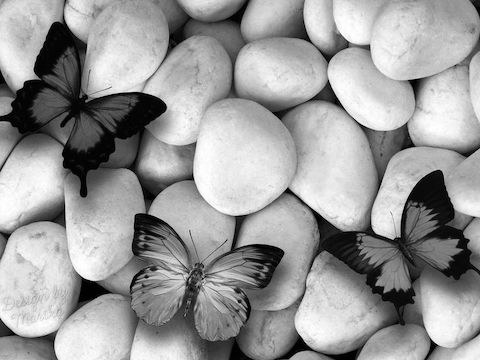

In [10]:
display(butterflies_grayscaled)

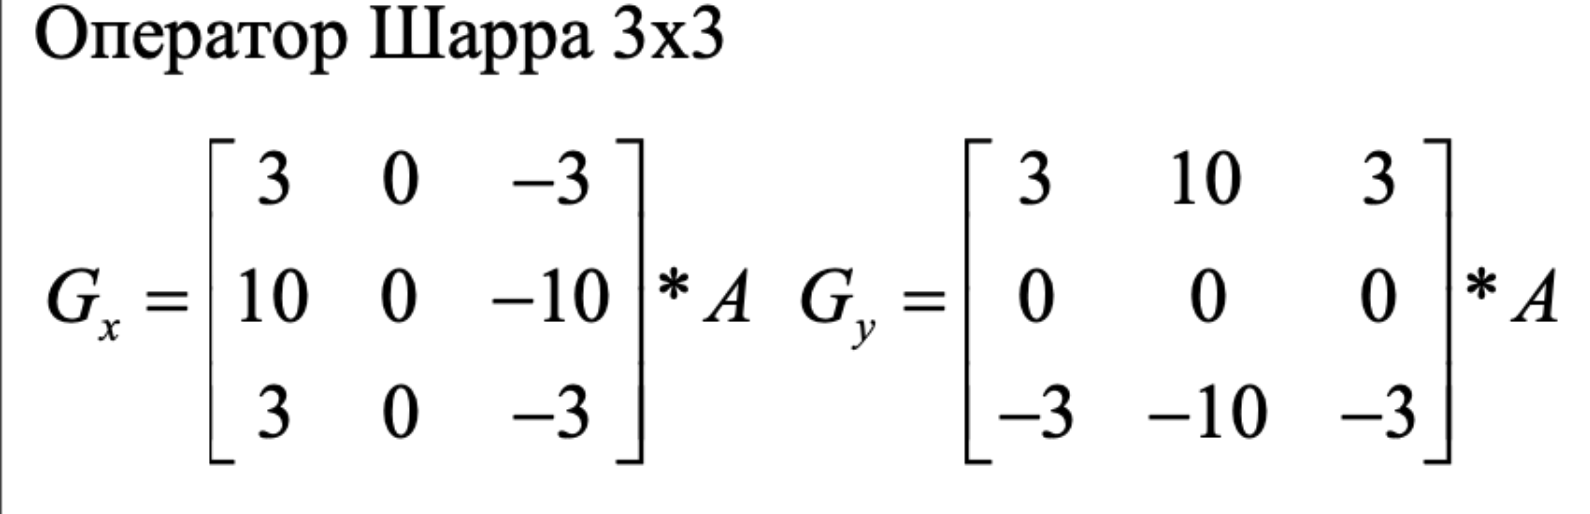

In [11]:
operator_sharra_x = np.array([[ 3,  0, -3], 
                              [10,  0,-10],
                              [ 3,  0, -3]])
operator_sharra_y = np.array([[ 3, 10,  3], 
                              [ 0,  0,  0],
                              [-3,-10, -3]])

In [79]:
def contour_selection(image, operator_x, operator_y, window_size):
    width, height = image.size
    
    gray_arr = np.asarray(image, dtype=np.uint8)
    
    G_x_matrix = np.zeros(shape=(height, width))
    G_y_matrix = np.zeros(shape=(height, width))
    G_matrix = np.zeros(shape=(height, width))
    
    # Adding zeroes on perimeter of matrix
    padded_gray_arr = np.pad(gray_arr, ((1, 1), (1, 1)), mode='constant') 
    for i in range(1, height+1): 
        for j in range(1, width+1): 
            i_min = max(i - window_size // 2, 0)
            i_max = min(i + window_size // 2, height+1)
            j_min = max(j - window_size // 2, 0)
            j_max = min(j + window_size // 2, width+1)
            
            window_matrix = padded_gray_arr[i_min:i_max+1, j_min:j_max+1]
            
            G_x = np.sum(operator_x * window_matrix)
            G_y = np.sum(operator_y * window_matrix)
            G = np.sqrt(G_x ** 2 + G_y ** 2)
#             print(G_x, G_y, G, G_x*G_x + G_y*G_y)

            G_x_matrix[i-1, j-1] = int(round(G_x))
            G_y_matrix[i-1, j-1] = int(round(G_y))
            G_matrix[i-1, j-1] = int(round(G))
            
    G_x_matrix_normalized = np.abs(G_x_matrix / np.max(G_x_matrix) * 255)
    G_y_matrix_normalized = np.abs(G_y_matrix / np.max(G_y_matrix) * 255)
    G_matrix_normalized = G_matrix / np.max(G_matrix) * 255
    
    t = np.mean(G_matrix_normalized) * 2.5
#     print(G_y_matrix_normalized)
    g_x_img = Image.fromarray(G_x_matrix_normalized.astype(np.uint8), mode='L')
    g_y_img = Image.fromarray(G_y_matrix_normalized.astype(np.uint8), mode='L')
    g_img = Image.fromarray(G_matrix_normalized.astype(np.uint8), mode='L')
    binary_img = Image.fromarray((G_matrix_normalized > t).astype(np.uint8) * 255, mode = 'L')
    return g_x_img, g_y_img, g_img, binary_img

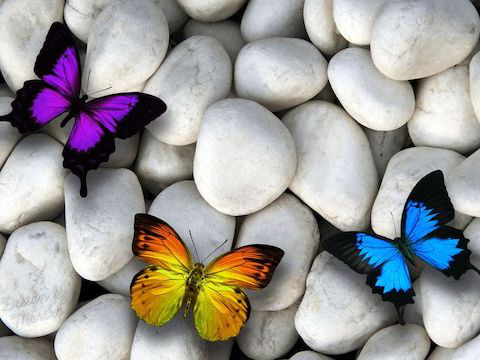

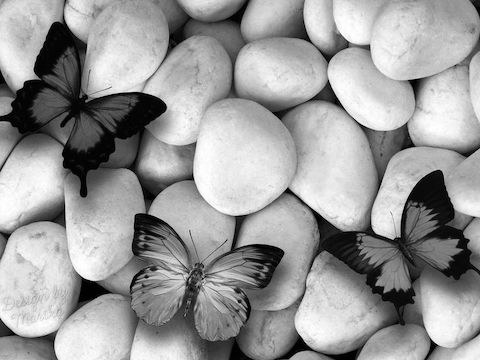

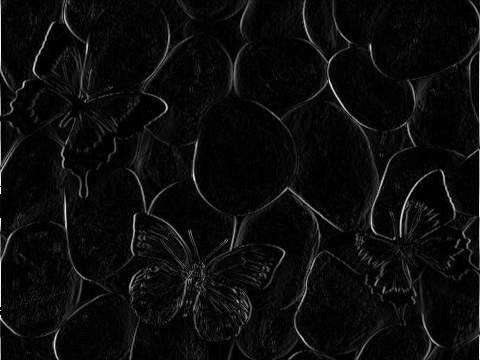

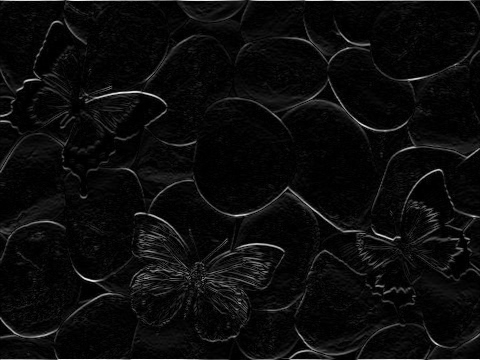

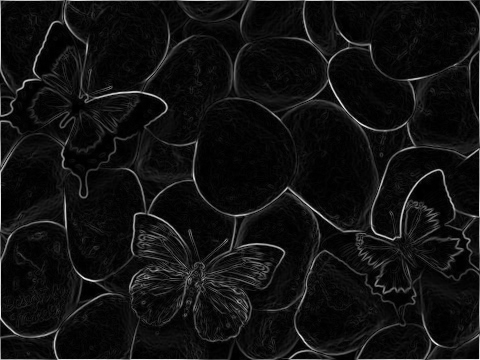

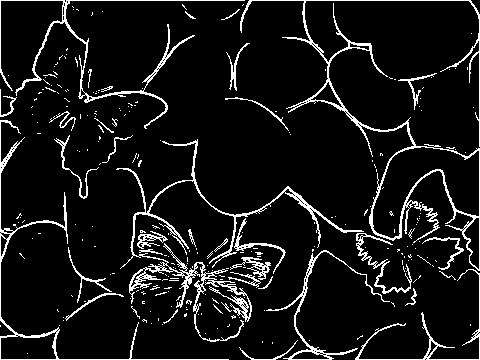

In [83]:
butterflies = Image.open('butterflies.png')
butterflies_grayscaled = photoshop_grayscale(butterflies)
g_x_img, g_y_img, g_img, binary_img = contour_selection(butterflies_grayscaled, operator_sharra_x, operator_sharra_y, 3)
display(butterflies, butterflies_grayscaled, g_x_img, g_y_img, g_img, binary_img)

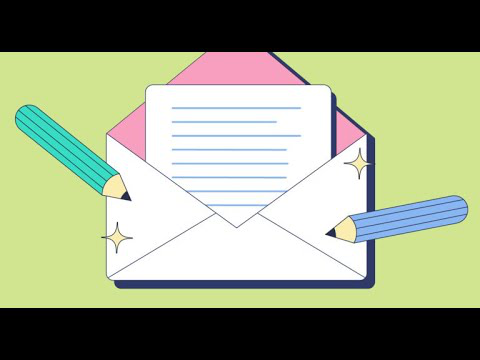

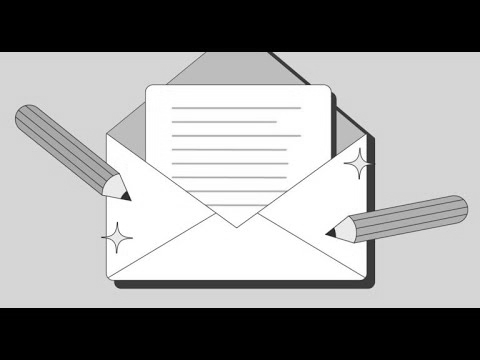

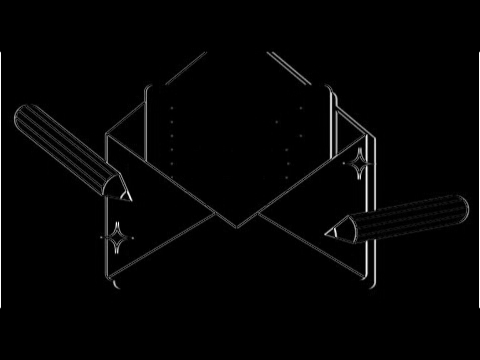

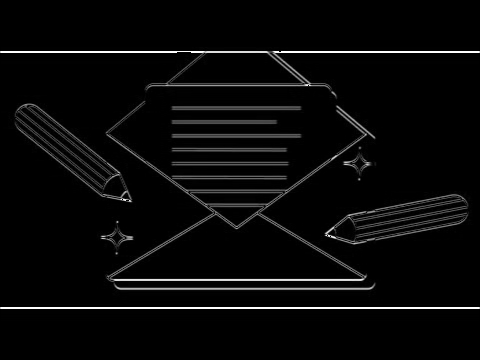

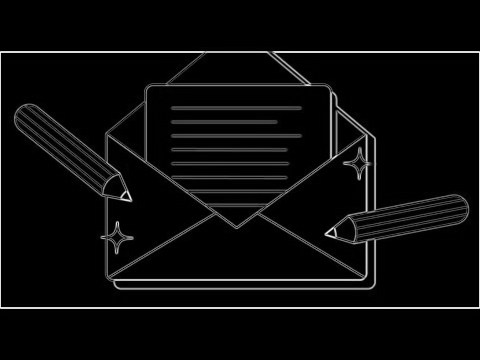

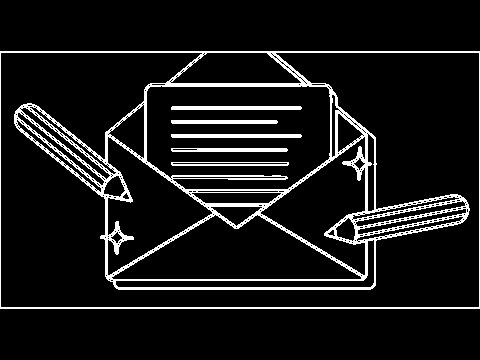

In [85]:
letter = Image.open('letter.png')
letter_grayscaled = photoshop_grayscale(letter)
g_x_img, g_y_img, g_img, binary_img = contour_selection(letter_grayscaled, operator_sharra_x, operator_sharra_y, 3)
display(letter, letter_grayscaled, g_x_img, g_y_img, g_img, binary_img)

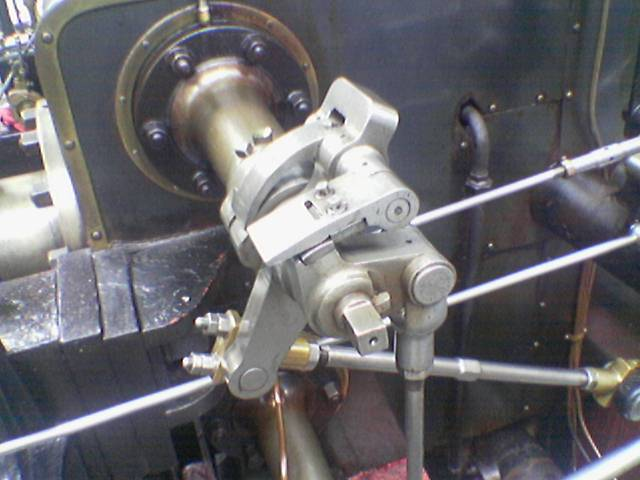

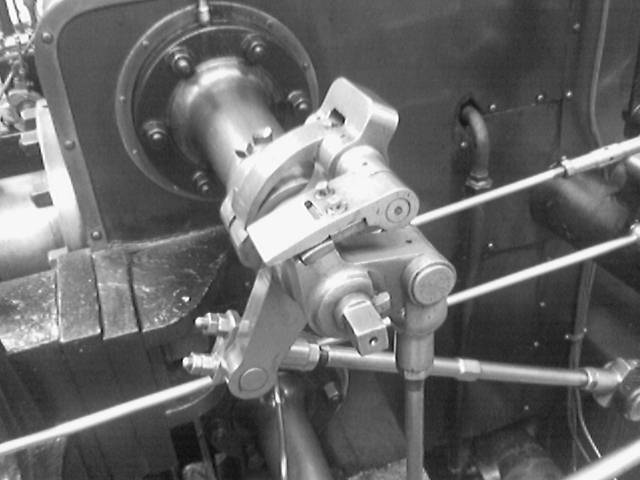

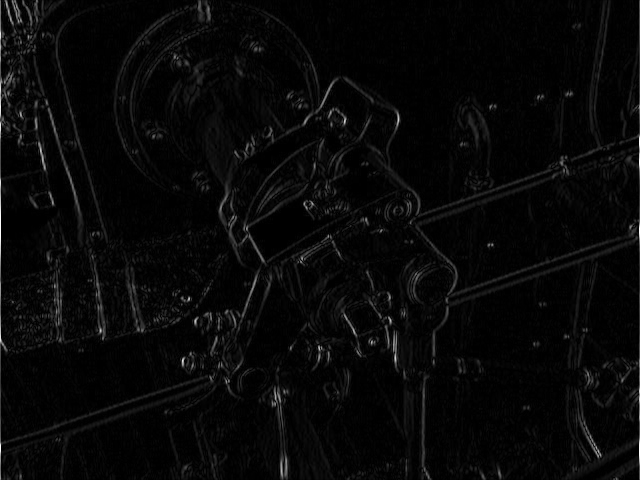

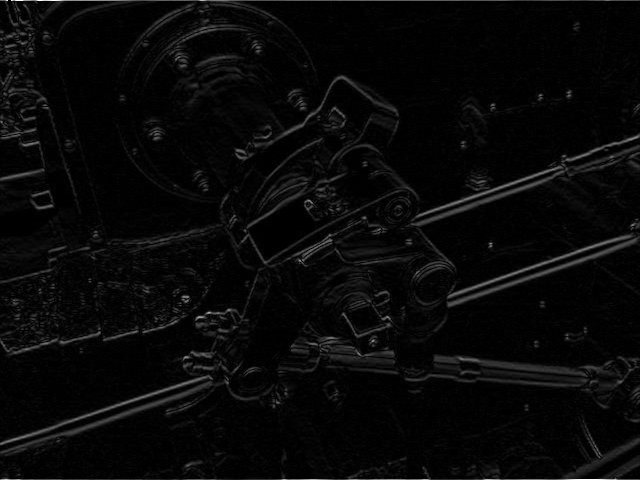

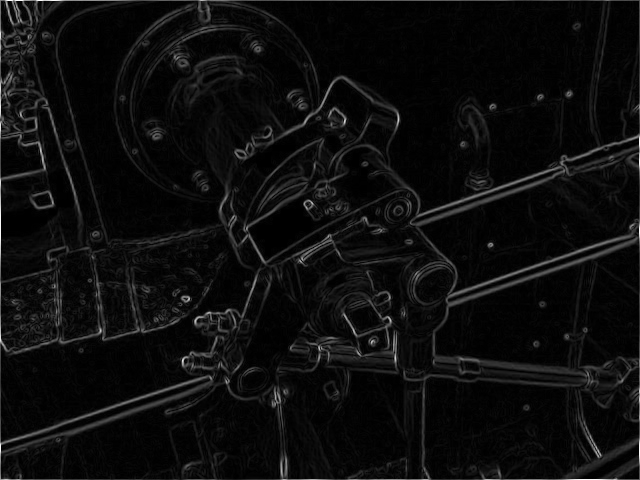

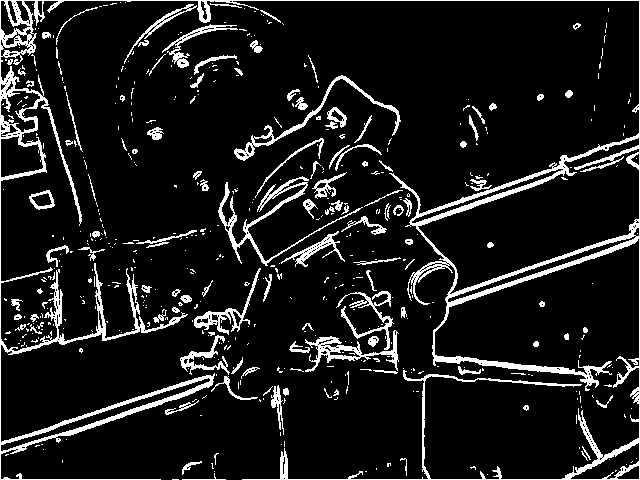

In [86]:
valve = Image.open('valve.png')
valve_grayscaled = photoshop_grayscale(valve)
g_x_img, g_y_img, g_img, binary_img = contour_selection(valve_grayscaled, operator_sharra_x, operator_sharra_y, 3)
display(valve, valve_grayscaled, g_x_img, g_y_img, g_img, binary_img)